## Siamese Neural Network

In [1]:
# First thing first, we import a bunch of useful packages
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import v2

### Generate dataset

As explained in the lectures, although we are given a database of images, the database does not constitute the dataset. To make up the dataset for Triplet Loss Function, we need to form a tuple of three images:
- **Anchor** image: The image to be compared with the other two.
- **Positive** image: This image refers to the same person in anchor image
- **Negative** image: This image shows a different person from the one in anchor image

In [2]:
DATA_DIR = './Person-Re-ID-Dataset/train/'
CSV_PATH = './Person-Re-ID-Dataset/train.csv'

df = pd.read_csv(CSV_PATH)
# We split the training set and validation set with the ratio 80% -- 20%.
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
# This cell is just a code test. I want to see the size
# of the image. I will use the code in this cell in the 
# definition of the class EfficientDataset
row = df.iloc[0]
one_image = Image.open(DATA_DIR + row.Anchor)
width, height = one_image.size
print(f"width = {width} | height = {height}")

width = 64 | height = 128


We will define a custom dataset that is subclass to the class `Dataset` imported from `torch.utils.data`. To define a subclass to `Dataset`, it is important to "redefine" three special functions 
- `__init__()`  
The class constructor `__init__()` needs no explanation. If you don't know what it is, you need to go back to the extra lecture on "Object Oriented Programming" uploaded on Moodle.
- `__len__()`  
The function `__len__()` is executed by using the Python function `len()` and returns the length of the dataset. In this case, of course "length" of the dataset refers to its "size".
- `__getitem__()`  
The function `__getitem__()` is executed when indexing into the dataset is done. For example, the statement `dataset[42]` is completely equivalent to the syntax `dataset.__getitem__(42)`.

There are two ways we can define the class Dataset.
1. In the first way, we can construct the dataset by simply connect the dataset to the dataframe given by the excel file "train.csv". Then, all of the essential processing will be done in `__getitem()`. In this manner, the constructor is executed extremely fast as it just involves variable assignment. However, when we access a training example, the process of reading images, and converting them into a torch tensor will be executed. If one single epoch is used, the loading and conversion of images into tensor are done only once. However, this process will be repeated as many as number of epochs. If the training is running through $50$ epochs, the loading and conversion process will be done $50$ times for the same set of images. The advantage of this method is memory saving while the disadvantage is the heavy computation and repeated computation. In programming, we normally have to decide to trade off the memory resources for computing speed and vice versa. As for our case, the set of images is very light and thus we don't want to adopt this method. To understand this point, read further to the **Not So Quick Note** below.
2. In the second way, the constructor will handles all of the data processing, including reading the images and converting them into torch tensor. Then, when we access an image via the method `__getitem__()`, it just returns the data that has been constructed and saved in the constructor `__init__()`. Particularly, in the constructor, we shall build a $5$-dimensional tensor described as follows. The first dimension corresponds to the number of examples in the dataset. The second dimension corresponds to the number of images in each example, that is equal to $3$ because a triplet of images is used for one example. The third dimension corresponds to the number of channels of one image, that is, again, equal to $3$ because of the RGB image format. The last two dimensions correspond to height $H$ and width $W$ of the image. All in all, we have the data tensor of size $(N, T, C, W, H)$ with $T = 3, C = 3, W = 64, H = 128$ and $N$ can take the value $N_\text{train}$ for the training dataset or $N_\text{valid}$ for the validation dataset.

In [4]:
class EfficientDataset(Dataset):
    
    def __init__(self, df):
        """
        df: dataframe storing the names of the images.
        """
        self.df = df
        df_size = len(self.df)
        one_image = Image.open(DATA_DIR + self.df.iloc[0].Anchor)
        width, height = one_image.size

        triplet_num, n_channels = 3, 3
        # Each data point in the dataset is a tripet of number: so 3
        # Each image has 3 channels: so another 3
        self.data = torch.zeros(size=(df_size, triplet_num, n_channels, height, width)) 
        to_tensor = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

        for idx in range(df_size):
            row = df.iloc[idx]
            anchor_img = Image.open(DATA_DIR + row.Anchor)
            positive_img = Image.open(DATA_DIR + row.Positive)
            negative_img = Image.open(DATA_DIR + row.Negative)
            self.data[idx,0] = to_tensor(anchor_img)
            self.data[idx,1] = to_tensor(positive_img)
            self.data[idx,2] = to_tensor(negative_img) 

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):

        return self.data[index,0], self.data[index,1], self.data[index,2]

<font color="red">**Not so quick note**</font>  
Initially, I write down the dataset like this
```python
class DatasetAPN(Dataset):

    def __init__(self, df):
        """
        df: dataframe storing the names of the images.
        """
        self.df = df        # attach the dataframe into
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):

        row = self.df.iloc[index]
        anchor_img = io.imread(DATA_DIR + row.Anchor)
        positive_img = io.imread(DATA_DIR + row.Positive)
        negative_img = io.imread(DATA_DIR + row.Negative)

        anchor_img = torch.from_numpy(anchor_img).permute(dims=(2, 0, 1)) / 255.0
        positive_img = torch.from_numpy(positive_img).permute(dims=(2, 0, 1)) / 255.0
        negative_img = torch.from_numpy(negative_img).permute(dims=(2, 0, 1)) / 255.0
        return anchor_img, positive_img, negative_img
```
Of course, this is not a good code design. Otherwise, I would not have deleted it and put it here. As you can see the dataset need to load the images again and again when the training process need to access the images. The strategy of loading images whenever the training process needs is advisable if we don't have enough memory. However, since the dataset has a very memory size, I decided to store all the images in a variable `self.data` as given in the above code and the images are already converted to *torch* tensors. So it is just much faster to access the images; it is just like accessing normal torch tensors. Of course, the `EffcientDataset` needs more time to process the images the first time it is constructed. For this reason, the constructor takes more time to run. Try the code with inefficient dataset for both loading and training process, you will understand my explanation here.

The following steps are idiomatic. You have learned these steps in the previous Jupyter Notebooks. Essentially, we create the dataset using the class `DatasetAPN` we defined above and then wrap them around by `DataLoader` so that we can easily load them in the training loop. Nothing fancy!

In [5]:
train_dataset = EfficientDataset(train_df)
valid_dataset = EfficientDataset(valid_df)
# Wrap datasets by data loader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

#### Visualization 

Let us try to load the images and visualize them. To make it easy for use later, we will write a function for this purpose and use this function.

In [6]:
def visualize_images(nrows, ncols, dataset, indices):
    channels, height, width = dataset[0][0].shape
    figsize = (2 * ncols, 1.4 * nrows)
    plt.figure(figsize=figsize)
    for i in indices:
        plt.subplot(nrows, ncols, i+1)
        anchor_img = train_dataset[i][0].permute((1, 2, 0))
        positive_img = train_dataset[i][1].permute((1, 2, 0))
        negative_img = train_dataset[i][2].permute((1, 2, 0))
        white_width = width//10
        white_space = torch.ones((height, white_width, channels))
        all_images = torch.cat((anchor_img, white_space, positive_img, white_space, negative_img), dim=1)
        plt.text(width//2, -8, "A")
        plt.text(3*width//2 + white_width, -8, "P")
        plt.text(5*width//2 + white_width, -8, "N")
        plt.imshow(all_images)

    plt.tight_layout()

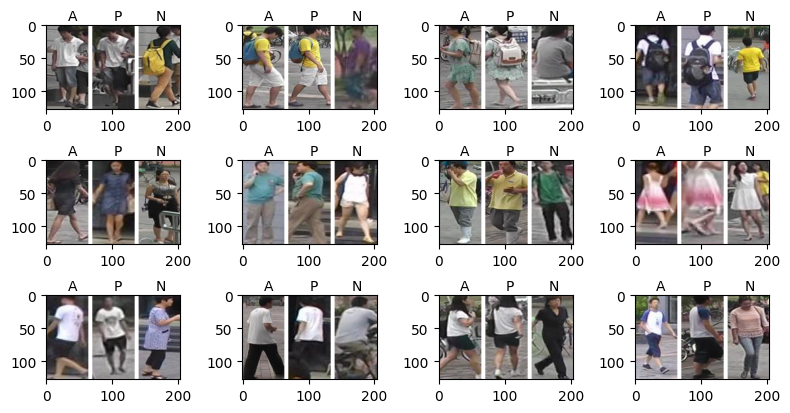

In [7]:
nrows, ncols = 3, 4     # change the number of rows and number of columns to see more/less triple of images
visualize_images(nrows, ncols, train_dataset, list(range(nrows * ncols)))

As you can see, the anchor $(A)$ and the positive $(P)$ images refer to the same person and the negative $(N)$ image refer to a different person from the anchor image.

### Define the model

In this notebook, we shall use the `efficientnet_b0` which is downloaded from `timm` package. You probably want to ask "why efficientnet". Well, I just want to provide you as much knowledge as possible. It does not mean that you cannot use other classic networks such as **VGG**, **ResNet** or even **AlexNet**. The final prediction won't change much by using these classic (and giant) convolution neural networks.

The return of the network, as already explained in the lecture, are the encodings of the input images. The "efficientnet" has the final module called "classifier". This module is a linear layer with the output size of $1000$ (see the code below). This efficient net is used for classification of $1000$ objects. As we want to use the encoding with the size $512$, we shall replace this final linear layer with the new linear layer so that the input size is equal to the old linear layer but the output size is equal to $512$. 

In [8]:
model = timm.create_model(model_name='efficientnet_b0', pretrained=True)
# As before, let us save the model architecture into a text file for reference later
model_architecture = str(model)
f = open("./efficientnet-architecture.txt", "w")
f.write(model_architecture)
f.close()

print(model) # We can see the model architecture by the print statement.
# We can keep this model and then replace the the last layer named "classifier".
# However, I want to build a model with specific class name. So I delete the
# model here to save memory.
del model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [9]:
# Define model class
class ModelAPN(nn.Module):

    def __init__(self, encoding_size=512):
        super(ModelAPN, self).__init__()

        self.efficientnet = timm.create_model("efficientnet_b0", pretrained=True)
        # Change the last linear layer to output 512-dimensional encoding
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features,
                                                 out_features=encoding_size)
        
    def forward(self, images):

        encodings = self.efficientnet(images)
        return encodings

In [10]:
# Create the model and transfer it to CUDA (if available)
model = ModelAPN()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device);       # semicolon is used to suppress the output (just like MATLAB code)


### Train the model

Now, we train the model using the training dataset and evaluate the model using the validation dataset. We shall sve the best state of the model using the loss function value obtained from using the validation set. We do this because we use batch training method. The loss function can go down and then up and thus the best model state, namely the set of parameters in the model, does not necessarily improve all the way of the training process. Therefore, we want to keep track of the best state and save the best state. Of course, different ML practitioners can have different training strategy. This strategy is, by no mean, necessarily the best strategy you can adopt. When you join industry, you can learn something better than you learn here.

In [11]:
# As the margin by default is set to 1.0, we don't need to define it.
# Nevertheless, feel free to try different values to see its effect
# on the result.

EPOCHS = 50
lr = 0.001

criterion = nn.TripletMarginLoss()      
nn.TripletMarginLoss?
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Init signature:
nn.TripletMarginLoss(
    margin: float = 1.0,
    p: float = 2.0,
    eps: float = 1e-06,
    swap: bool = False,
    size_average=None,
    reduce=None,
    reduction: str = 'mean',
)
Docstring:     
Creates a criterion that measures the triplet loss given an input
tensors :math:`x1`, :math:`x2`, :math:`x3` and a margin with a value greater than :math:`0`.
This is used for measuring a relative similarity between samples. A triplet
is composed by `a`, `p` and `n` (i.e., `anchor`, `positive examples` and `negative
examples` respectively). The shapes of all input tensors should be
:math:`(N, D)`.

The distance swap is described in detail in the paper `Learning shallow
convolutional feature descriptors with triplet losses`_ by
V. Balntas, E. Riba et al.

The loss function for each sample in the mini-batch is:

.. math::
    L(a, p, n) = \max \{d(a_i, p_i) - d(a_i, n_i) + {\rm margin}, 0\}


where

.. math::
    d(x_i, y_i) = \left\lVert {\bf x}_i - {\bf y}_i \right\rVert_

In [ ]:
n_epoch_prints = EPOCHS
print_every = int(EPOCHS // n_epoch_prints)
best_average_loss = torch.inf
for epoch in range(EPOCHS):
    print("Training process starts...")
    if epoch % print_every == 0:
        print(f"Epoch [{epoch} / {EPOCHS}]")
    
    # Training phase
    #==========================================================
    model.train()
    total_loss = 0
    for A, P, N in train_dataloader:
        optimizer.zero_grad()
        # A = anchor, P = positive, N = negative
        A, P, N = A.to(device), P.to(device), N.to(device)
        A_encodings = model(A)      # compute encodings for three images in the triplet
        P_encodings = model(P)
        N_encodings = model(N)

        loss = criterion(A_encodings, P_encodings, N_encodings)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_average_loss = total_loss / len(train_dataloader)

    # Evaluation phase
    #==========================================================
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for A, P, N in valid_dataloader:
            A, P, N = A.to(device), P.to(device), N.to(device)
            A_encodings = model(A)
            P_encodings = model(P)
            N_encodings = model(N)
        
        loss = criterion(A_encodings, P_encodings, N_encodings)
        total_loss += loss.item()

    valid_average_loss = total_loss / len(valid_dataloader)

    if valid_average_loss < best_average_loss:
        torch.save(model.state_dict(), './best_model_asian_market.pt')
        best_valid_loss = valid_average_loss
        print("Model weights are updated in the pt-file")

    if epoch % print_every == 0:
        print(f"Train loss: {train_average_loss:.3f} | Valid loss: {valid_average_loss:.3f}")

Training process starts...
Epoch [0 / 50]
Model weights are updated in the pt-file
Train loss: 0.623 | Valid loss: 0.031
Training process starts...
Epoch [1 / 50]
Model weights are updated in the pt-file
Train loss: 0.268 | Valid loss: 0.016
Training process starts...
Epoch [2 / 50]
Model weights are updated in the pt-file
Train loss: 0.172 | Valid loss: 0.006
Training process starts...
Epoch [3 / 50]
Model weights are updated in the pt-file
Train loss: 0.114 | Valid loss: 0.004
Training process starts...
Epoch [4 / 50]
Model weights are updated in the pt-file
Train loss: 0.090 | Valid loss: 0.007
Training process starts...
Epoch [5 / 50]
Model weights are updated in the pt-file
Train loss: 0.087 | Valid loss: 0.014
Training process starts...
Epoch [6 / 50]
Model weights are updated in the pt-file
Train loss: 0.065 | Valid loss: 0.004
Training process starts...
Epoch [7 / 50]
Model weights are updated in the pt-file
Train loss: 0.054 | Valid loss: 0.010
Training process starts...
Epoch

### Inference

#### Derive encodings
Now that the model has been trained so that the encoding for each image is unique. We will compute the encodings and store them into the excel files so that they can be used in the future. This step is useful when we have very large database of persons. If we do not have a large database, this step, of course, does not take much computational time. If you execute the code below, you see that in our case, the database is quite large. So, it is useful to record the encodings into an excel file so that we can load them later easier.


#### Compute Euclidean distances between encodings
To make inference, we need to compute the Euclidean distance between two encodings, i.e., the Euclidean distance between two vectors. In this way, we can measure "how far" two images are from each other. If the distance between two images is larger than a threshold $\tau$, we can conclude the two images do not refer to the same person. Otherwise, they refer to the same person.

In [14]:
# Derive encodings

anchor_names = df['Anchor']

to_tensor = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
encodings = torch.zeros(size=(len(df), 512))
with torch.no_grad():
    for i, fname in tqdm(enumerate(anchor_names)):
        img = Image.open(DATA_DIR + fname)
        img = to_tensor(img).to(device)
        encoding = model(img.unsqueeze(0))
        encodings[i] = encoding

4000it [01:00, 66.48it/s]


In [15]:
encodings_np = encodings.numpy()
encodings_df = pd.DataFrame(encodings)
asian_market_encodings = pd.concat([anchor_names, encodings_df], axis=1)

asian_market_encodings.to_csv('./encodings_asian_market.csv', index=False)

In [16]:
def euclidean_distance(encoding1, encoding2):
    diff = np.squeeze(encoding1 - encoding2)
    distance = np.sqrt(np.dot(diff, diff))
    return distance

#### Make inference for one image

Let us now make inference for one image. By inference, we mean to compute the encodings and for all the images in the database. Then, we choose the first few images that are close the anchor image. Of course, we need a threshold to decide whether the images that are closest to the anchor image refer to the same person.

In [17]:
df_size = len(df)
idx = np.random.randint(df_size)        # just random image for the anchor
rest_idx = np.setdiff1d(np.arange(df_size), idx)
img_name = asian_market_encodings['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = to_tensor(Image.open(img_path))

In [18]:
model.eval()
with torch.no_grad():
    img = img.to(device)
    img_encoding = model(img.unsqueeze(0))
    img_encoding = img_encoding.detach().cpu().numpy()

In [19]:
distances = np.zeros(len(df))
all_encodings = asian_market_encodings.iloc[:,1:].to_numpy()
for i in range(all_encodings.shape[0]):
    distances[i] = euclidean_distance(img_encoding, all_encodings[i])

sorted_idx = np.argsort(distances)

#### Visualization for inferences

In [20]:
import networkx as nx 
from skimage import io
import matplotlib.pyplot as plt

def plot_closest_imgs(anc_img_names, DATA_DIR, image, img_path, closest_idx, distance, no_of_closest = 10):

    G=nx.Graph()

    S_name = [img_path.split('/')[-1]]

    for s in range(no_of_closest):
        S_name.append(anc_img_names.iloc[closest_idx[s]])

    for i in range(len(S_name)):
        image = io.imread(DATA_DIR + S_name[i])
        G.add_node(i,image = image)
        
    for j in range(1,no_of_closest + 1):
        G.add_edge(0,j,weight=distance[closest_idx[j-1]])
        

    pos=nx.kamada_kawai_layout(G)

    fig=plt.figure(figsize=(20,20))
    ax=plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw_networkx_edges(G,pos,ax=ax)

    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)

    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform

    piesize=0.1 # this is the image size
    p2=piesize/2.0
    for n in G:
        xx,yy=trans(pos[n]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[n]['image'])
        a.set_title(S_name[n][0:4])
        a.axis('off')
    ax.axis('off')
    plt.show()

c:\Users\ln69g\AppData\Local\anaconda3\envs\py3.12\Lib\site-packages\networkx\drawing\layout.py:724: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


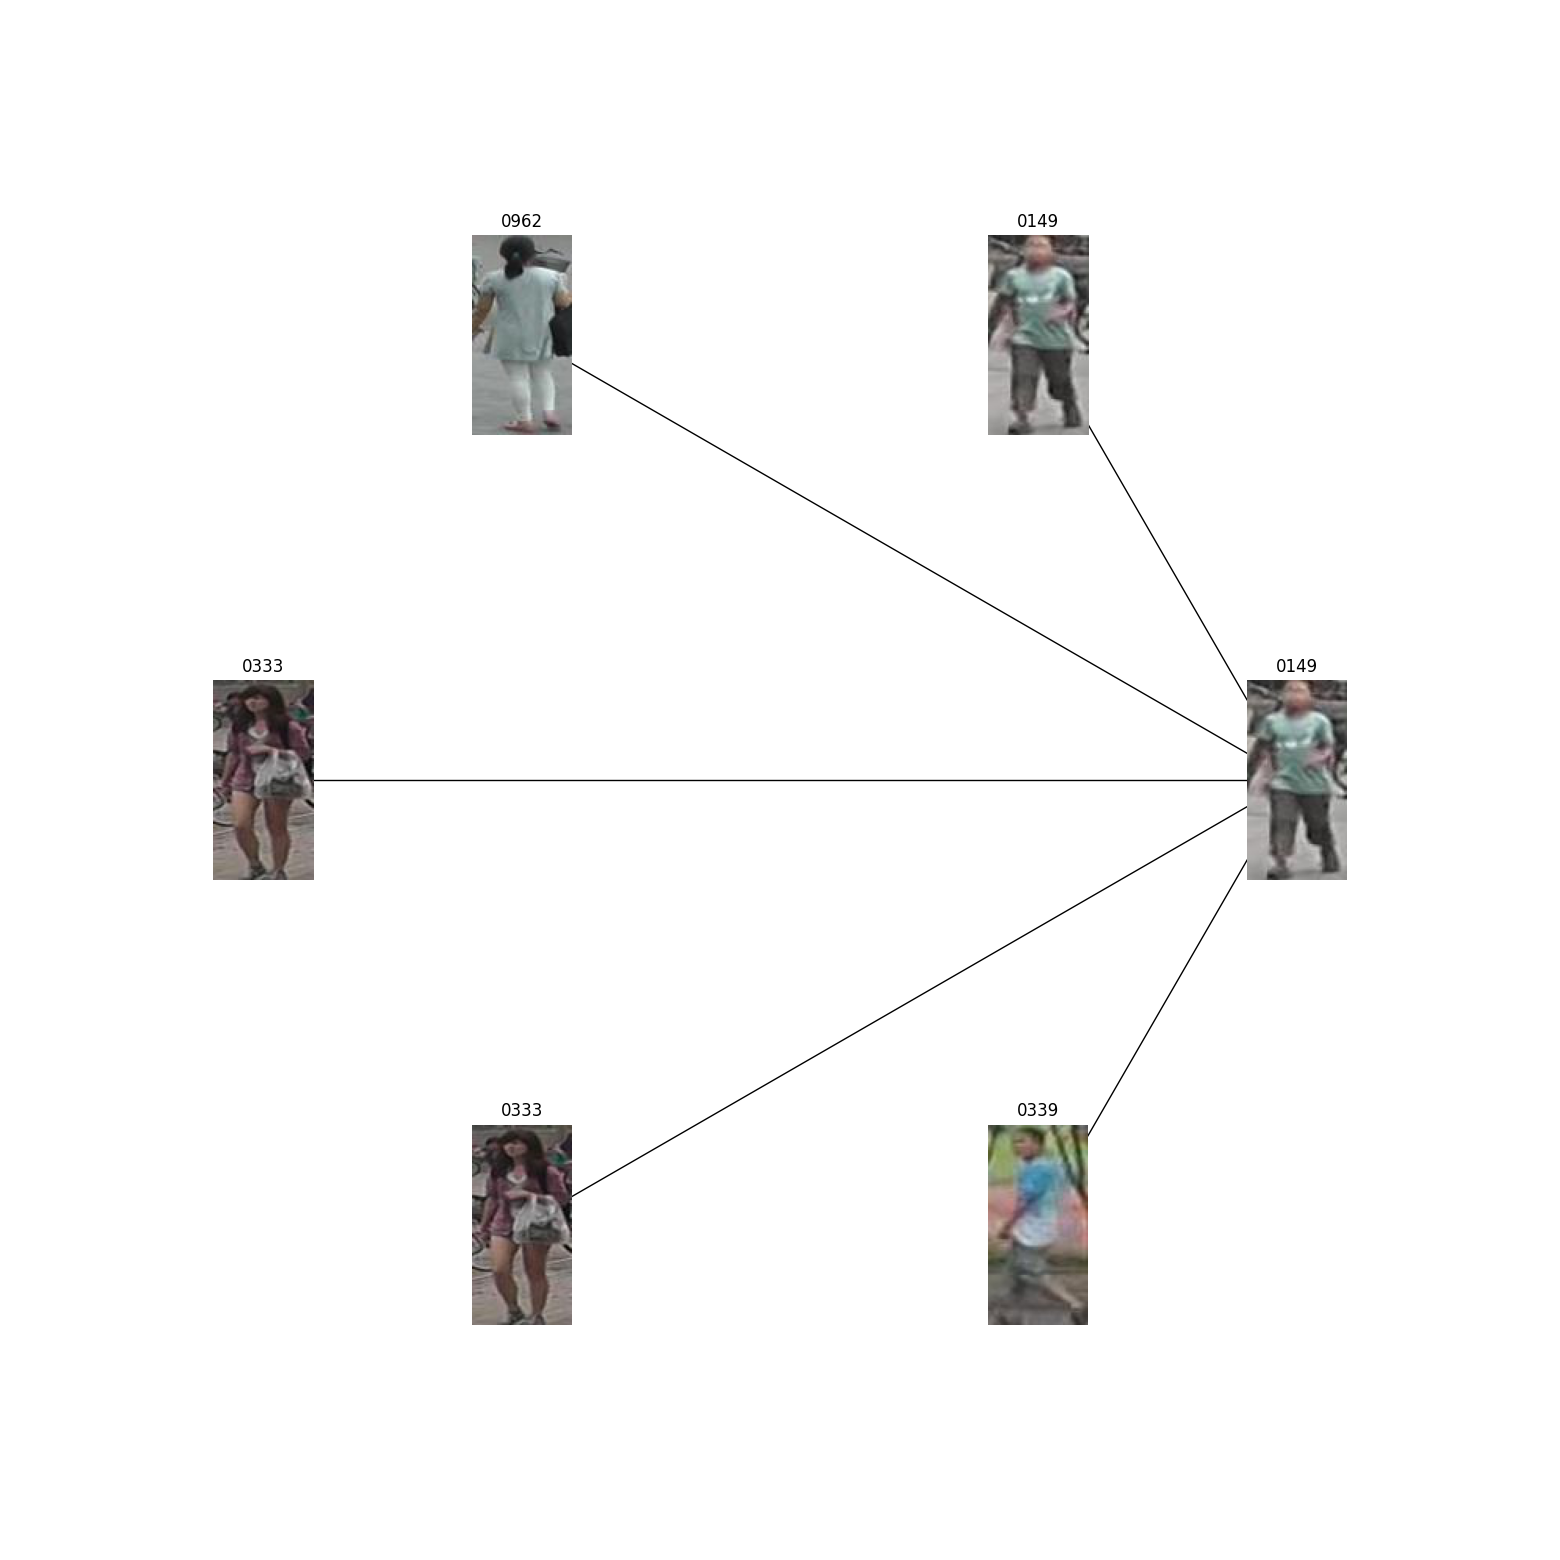

In [21]:
plot_closest_imgs(anchor_names, DATA_DIR, img, img_path, sorted_idx, distances, no_of_closest=5)